In [1]:
import os
import numpy as np
import h5py as h5
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import argparse
import pdb
from functools import partial
from copy import deepcopy
from tqdm.notebook import tqdm
import pickle as pkl
import json

import jax
import jax.numpy as jnp
import equinox as eqx
import optax

import samplers
import models
import main
import main_utils
import opto
import ih_paper_plot_utils

%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
base_folder = './ih_paper_reprod/main_paper_is5_ih3_pt2'
STRONGEST_IH = 3
PT_HEAD = 2
PT_HEAD_OTHER = 6
PT_HEAD_MULTI = '1,2,5'

BATCH_SIZE = 1024 # not optimized, could be played around with

# Appendix D: Additional details on clamping

## Figure 7

Graft experiments, showing that which seed we graft from greatly affects dynamics

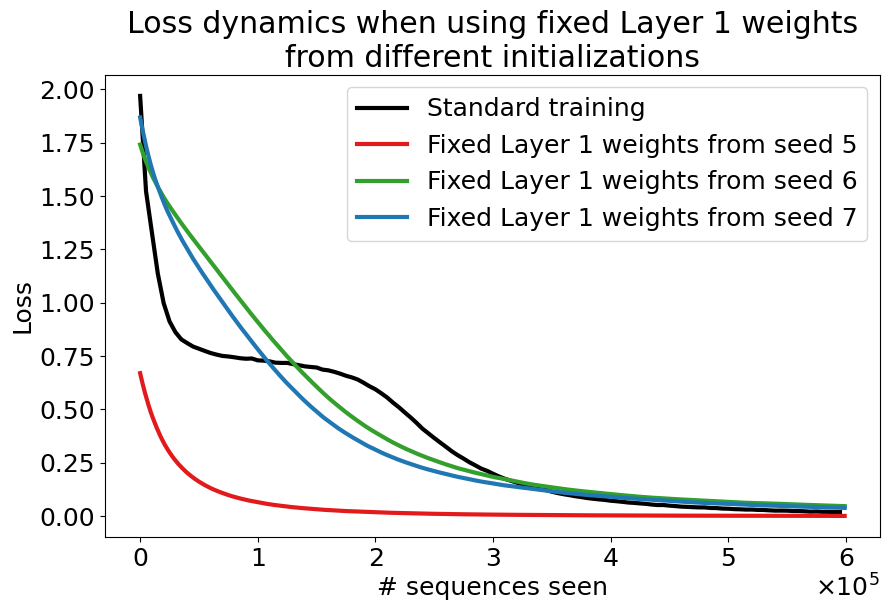

In [64]:
colors = np.array([[227,26,28], [51,160,44], [31,120,180], [152,78,163]])/256
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)

max_iters = 6e5

# Standard training loss
f = h5.File(f'{base_folder}/omniglot50_rl5/log.h5', 'r')
mask = f['eval_iter'][:] < max_iters
axs.plot(f['eval_iter'][:][mask], np.mean(f['fsl_train']['loss'], axis=1)[mask], 
         color='k', label='Standard training', lw=3)
f.close()

for i, seed in enumerate([5,6,7]):
    f = h5.File(f'{base_folder}/omniglot50_rl5_graft_l0_from_is{seed}/log.h5', 'r')
    mask = f['eval_iter'][:] < max_iters
    axs.plot(f['eval_iter'][:][mask], np.mean(f['fsl_train']['loss'], axis=1)[mask], 
             color=colors[i % len(colors)], label=f'Fixed Layer 1 weights from seed {seed}', lw=3)
    f.close()
axs.legend()
axs.set_xlabel('# sequences seen')
axs.set_ylabel('Loss')
axs.set_title('Loss dynamics when using fixed Layer 1 weights\nfrom different initializations')

formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
axs.xaxis.set_major_formatter(formatter)

fig.savefig(f'{base_folder}/figures/appendix_figure_7.pdf')

## Figure 8

Insensitivity to which Layer 1 heads are fixed to previous token attention patterns, unless all heads are fixed to this pattern. I think fixing all heads to the PT attention pattern causes issues since it disables V-composition (which appears to be useful for our task).

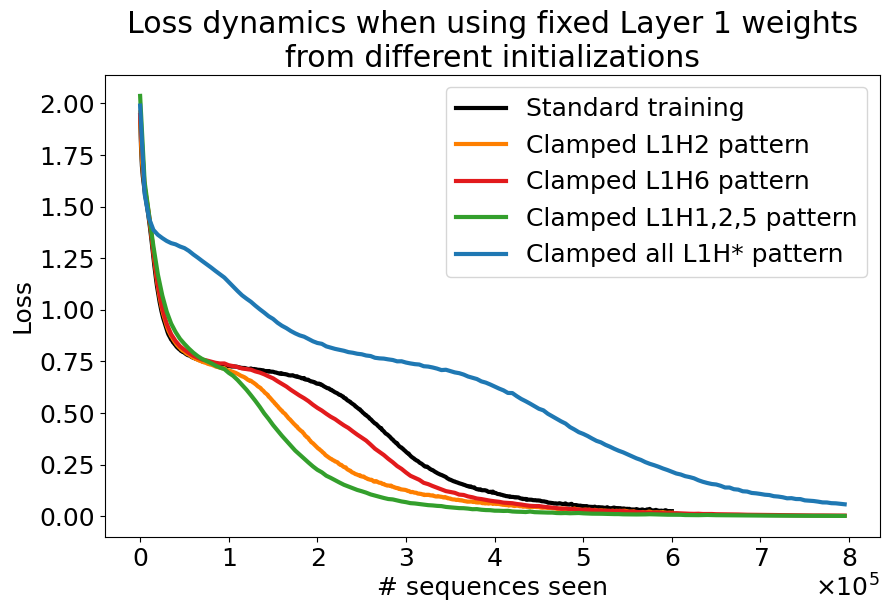

In [5]:
colors = np.array([[0,0,0], [255,127,0], [227,26,28], [51,160,44], [31,120,180], [152,78,163]])/256
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)

max_iters = 8e5

runs = {'Standard training': 'omniglot50_rl5_noclamp',
        f'Clamped L1H{PT_HEAD} pattern': 'omniglot50_rl5_perfect_prev_tok_attn_single',
        f'Clamped L1H{PT_HEAD_OTHER} pattern': 'omniglot50_rl5_perfect_prev_tok_attn_single_other',
        f'Clamped L1H{PT_HEAD_MULTI} pattern': 'omniglot50_rl5_perfect_prev_tok_attn_multi',
        'Clamped all L1H* pattern': 'omniglot50_rl5_perfect_prev_tok_attn_all'}

for i, r in enumerate(runs):
    f = h5.File(f'{base_folder}/{runs[r]}/log.h5', 'r')
    mask = f['eval_iter'][:] < max_iters
    axs.plot(f['eval_iter'][:][mask], np.mean(f['fsl_train']['loss'], axis=1)[mask], 
             color=colors[i % len(colors)], label=r, lw=3)
    f.close()
axs.legend()
axs.set_xlabel('# sequences seen')
axs.set_ylabel('Loss')
axs.set_title('Loss dynamics when using fixed Layer 1 weights\nfrom different initializations')

formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
axs.xaxis.set_major_formatter(formatter)

fig.savefig(f'{base_folder}/figures/appendix_figure_8.pdf')

## Figure 9

This Figure is generated by `appendix_paper_runs.sh`. See `simple_model_solver.py` for implementation.

## Figure 10

We first compute the analogous progress measure curves. To do this, we reconstruct the training dataset

In [4]:
opts = main_utils.get_opts_from_json_file(f'{base_folder}/omniglot50_rl5_noclamp/config.json')

data = main_utils.get_data_from_opts(opts)
print(data.shape)

splits = main_utils.get_splits_from_opts(opts, data.shape)
model = main_utils.get_model_from_opts(opts, (data.shape[-1], ))
fwd_fn_from_train_noclamp = opto.make_fn_from_opts(opts)

(1623, 5, 512)
data shape 0: 1623 class split: [50, 1473, 100]
Splitting fs relabelings with train: 8, val: 2, test: 0
Opto being used...


In [5]:
n_classes = opts.class_split[0]
temp = np.broadcast_to(splits['class']['train'], (n_classes, n_classes))
all_pairs = jnp.vstack([temp.T.reshape(-1), temp.reshape(-1)]).T
class_pairs = all_pairs[all_pairs[:, 0] != all_pairs[:, 1]]

### Get all label pairs
raw_labels = splits['relabeling']['train']
label_pairs = jnp.concatenate([raw_labels, raw_labels[:, ::-1]], axis=0)

### Make product of class pairs and label pairs
total = class_pairs.shape[0]*label_pairs.shape[0]
all_class_pairs = jnp.broadcast_to(class_pairs, (label_pairs.shape[0], *class_pairs.shape)).reshape(total, class_pairs.shape[1])
all_label_pairs = jnp.broadcast_to(label_pairs[:, None, :], (label_pairs.shape[0], class_pairs.shape[0], label_pairs.shape[1])).reshape(total, label_pairs.shape[1])

duplicate = lambda x: jnp.concatenate([jnp.concatenate([x, x[:, 0:1]], axis=1), jnp.concatenate([x, x[:, 1:2]], axis=1)], axis=0)

##### Load data
all_data = dict()
all_data['class_pairs'] = duplicate(all_class_pairs)
all_data['examples'] = data[all_data['class_pairs'], 0]
all_data['labels'] = duplicate(all_label_pairs)
all_data['correct_ind'] = jnp.concatenate([jnp.zeros(all_class_pairs.shape[0]), jnp.ones(all_class_pairs.shape[0])]).astype(int)
##### done loading data

all_data['correct_ind'].shape

(78400,)

In [6]:
# Make a forward fn that returns the activations we care about

# We use this construction to allow for optogenetic based progress measures later
# (e.g., appendix figure 10, later in the notebook)
parser = argparse.ArgumentParser()
opto.add_args_to_parser(parser)
default_opto_opts = parser.parse_args(args=[])

opt_state = main_utils.get_optimizer_from_opts(opts).init(eqx.filter(model, eqx.is_array))

ckpt_fmt = {'iter': -1, 
            'seeds': {'eval_model_seed': jax.random.PRNGKey(0),
                      'train_data_seed': jax.random.PRNGKey(0),
                      'train_model_seed': jax.random.PRNGKey(0)}, 
            'opt_state': opt_state,
            'model': model}

In [7]:
# Figure out which indices we'd like to plot, allowing for downsampling (for speed)
num_ckpts_to_plot = 100 # downsampled compared to paper for speed!
max_iters = 6e5

filenames = sorted(os.listdir(f'{base_folder}/omniglot50_rl5_noclamp/checkpoints/'))
iters = np.array([int(cn.split('.')[0]) for cn in filenames])

inds_to_plot = ih_paper_plot_utils.get_closest_inds(np.linspace(iters[0], max_iters, num_ckpts_to_plot), iters)

In [10]:
# We make two forward fns, one for each progress measure
progress_fns = dict()
temp_opts = deepcopy(default_opto_opts)
temp_opts.opto_ablate_heads = ['1:{}'.format(l) for l in range(8) if l != STRONGEST_IH]
temp_opts.opto_prev_token_heads = ['0:2']
progress_fns['pt_attn_clamp'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train_noclamp), 
                                                                 batch_size=BATCH_SIZE)

temp_opts = deepcopy(default_opto_opts)
temp_opts.opto_ablate_heads = ['1:{}'.format(l) for l in range(8) if l != STRONGEST_IH]
temp_opts.opto_induction_heads = ['1:3']
progress_fns['match_clamp'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train_noclamp), 
                                                                 batch_size=BATCH_SIZE)

Opto being used...
Opto being used...


In [11]:
series = {k: [] for k in progress_fns}
for ind in tqdm(inds_to_plot):
    ckpt_fname = f'{base_folder}/omniglot50_rl5_noclamp/checkpoints/{filenames[ind]}'
    ckpt = eqx.tree_deserialise_leaves(ckpt_fname, ckpt_fmt)
    for k in progress_fns:
        series[k].append(jnp.mean(progress_fns[k](ckpt['model'],
                                         all_data['examples'], 
                                         all_data['labels'], 
                                         key=jax.random.PRNGKey(0))['loss'])
                        )

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/singha/miniconda3/envs/microformer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


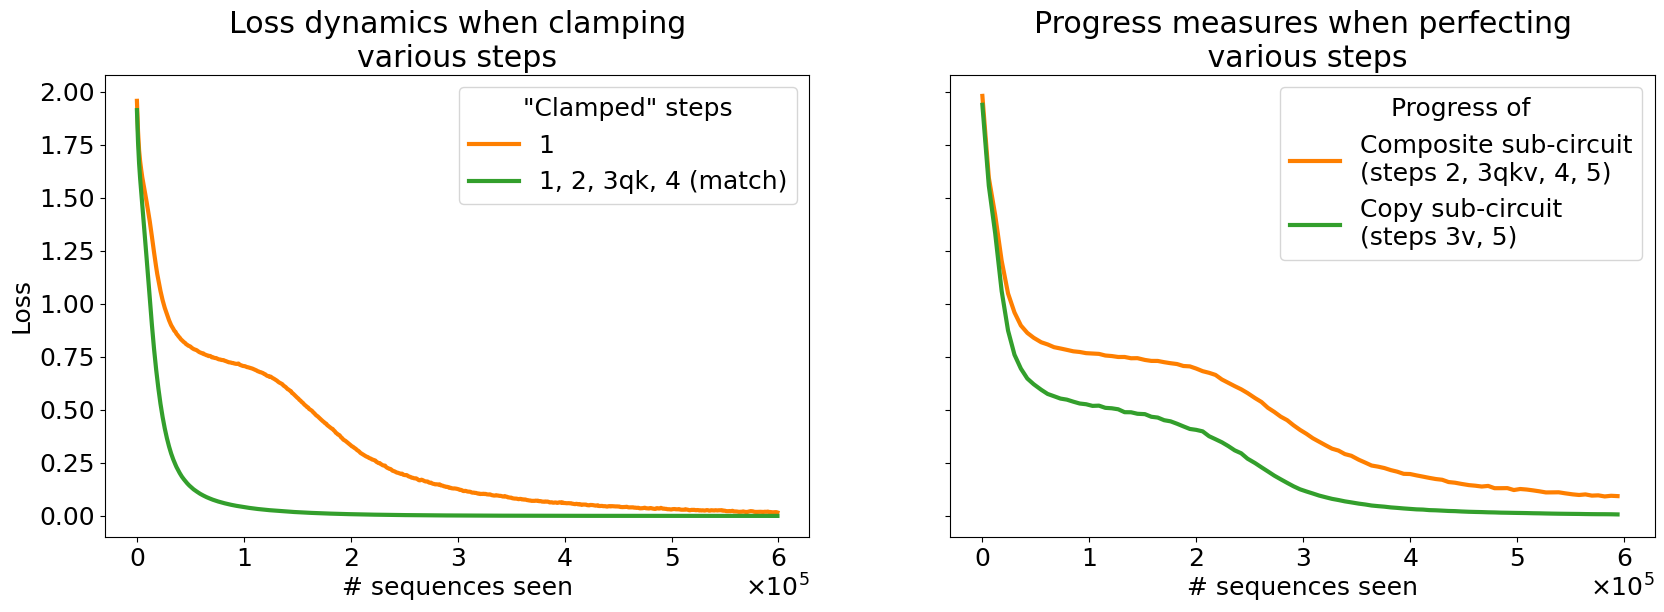

In [12]:
# Comparing clamping to progress measures
runs = {'1': 'omniglot50_rl5_perfect_prev_tok_attn_single',
        '1, 2, 3qk, 4 (match)': 'omniglot50_rl5_perfect_match'}

colors = np.array([[255,127,0], [51,160,44]])/256
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(20,6)
for i, r in enumerate(runs):
    f = h5.File(f'{base_folder}/{runs[r]}/log.h5'.format(runs[r]), 'r')
    mask = f['eval_iter'][:] < max_iters
    axs[0].plot(f['eval_iter'][:][mask], np.mean(f['fsl_train']['loss'], axis=1)[mask], color=colors[i % len(colors)], label=r, lw=3)
    f.close()
axs[0].legend(title='"Clamped" steps')
axs[0].set_xlabel('# sequences seen')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss dynamics when clamping\nvarious steps')

formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
axs[0].xaxis.set_major_formatter(formatter)

axs[1].set_title('Progress measures when perfecting\n various steps')
mask = iters[inds_to_plot] < max_iters
axs[1].plot(iters[inds_to_plot][mask], np.array(series['pt_attn_clamp'])[mask], color= colors[0], label="Composite sub-circuit\n(steps 2, 3qkv, 4, 5)", lw=3)
axs[1].plot(iters[inds_to_plot][mask], np.array(series['match_clamp'])[mask], color= colors[1], label="Copy sub-circuit\n(steps 3v, 5)", lw=3)

axs[1].legend(title='Progress of')
axs[1].set_xlabel('# sequences seen')
fig.savefig(f'{base_folder}/figures/appendix_figure_10.pdf')

# Appendix E: Role of layer 1 heads

Some of these blocks just produce the relevant numbers for the tables

## Table 1

This one is hardcoded to the identified PT heads on this init seed (5). PT patterns should be inspected before conducting this analysis if running on other seeds

In [8]:
opts = main_utils.get_opts_from_json_file(f'{base_folder}/omniglot50_rl5/config.json')
fwd_fn_from_train = opto.make_fn_from_opts(opts)

In [15]:
table1_fns = dict()

temp_opts = deepcopy(default_opto_opts)
temp_opts.opto_ablate_heads = ['0:1', '0:2', '0:5']
temp_opts.opto_preserve_patterns = True
table1_fns['ablate125_preserve_patterns'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                                 batch_size=1024)

temp_opts = deepcopy(default_opto_opts)
temp_opts.opto_ablate_heads = ['0:1', '0:2', '0:5']
temp_opts.opto_preserve_values = True
table1_fns['ablate125_preserve_values'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                                 batch_size=1024)

temp_opts = deepcopy(default_opto_opts)
temp_opts.opto_ablate_heads = ['0:0', '0:3', '0:4', '0:6', '0:7']
temp_opts.opto_preserve_patterns = True
table1_fns['ablate03467_preserve_patterns'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                                 batch_size=1024)

temp_opts = deepcopy(default_opto_opts)
temp_opts.opto_ablate_heads = ['0:0', '0:3', '0:4', '0:6', '0:7']
temp_opts.opto_preserve_values = True
table1_fns['ablate03467_preserve_values'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                                 batch_size=1024)

Opto being used...
Opto being used...
Opto being used...
Opto being used...


In [9]:
all_ckpt_fnames = sorted(os.listdir(f'{base_folder}/omniglot50_rl5/checkpoints/'))
final_model = eqx.tree_deserialise_leaves(f'{base_folder}/omniglot50_rl5/checkpoints/{all_ckpt_fnames[-1]}', 
                                   ckpt_fmt)['model']
init_model = eqx.tree_deserialise_leaves(f'{base_folder}/omniglot50_rl5/checkpoints/{all_ckpt_fnames[0]}', 
                                   ckpt_fmt)['model']

In [17]:
table_1_stats = dict()
for k in tqdm(table1_fns):
    out = table1_fns[k](final_model, 
                        all_data['examples'], 
                        all_data['labels'], 
                        key=jax.random.PRNGKey(0))
    table_1_stats[k] = np.mean(out['acc'])

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/singha/miniconda3/envs/microformer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


In [18]:
print(table_1_stats)

{'ablate125_preserve_patterns': Array(0.9985332, dtype=float32), 'ablate125_preserve_values': Array(0.69868624, dtype=float32), 'ablate03467_preserve_patterns': Array(0.34266582, dtype=float32), 'ablate03467_preserve_values': Array(0.9931888, dtype=float32)}


## Figure 11: Wiring diagrams

This one is quite expensive, lots of different manipulations (64 * 2 * 2 + 8 = 264), but only applied to final model.

Needed to split into two separate cells to avoid crashing laptop... not sure why it crashes, since memory cleanup is being done via `del` as far as I can tell. Regardless, as a result, we load in values from the pkls to use for the plots.

In [19]:
wiring_diagram_fns_a = dict()
for l in range(8):
    l1_heads = ['1:{}'.format(lay) for lay in range(8) if lay != l]
    temp_opts = deepcopy(default_opto_opts)
    temp_opts.opto_ablate_heads = l1_heads
    wiring_diagram_fns_a['only_l1h{}'.format(l)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                              batch_size=BATCH_SIZE)
    for l2 in range(8):
        temp_opts = deepcopy(default_opto_opts)
        temp_opts.opto_ablate_heads = l1_heads + ['0:{}'.format(l2)]
        temp_opts.opto_preserve_patterns = True
        wiring_diagram_fns_a['only_l1h{}_remove_l0h{}_pp'.format(l, l2)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                              batch_size=BATCH_SIZE)
    
        temp_opts = deepcopy(default_opto_opts)
        temp_opts.opto_ablate_heads = l1_heads + ['0:{}'.format(l2)]
        temp_opts.opto_preserve_values = True
        wiring_diagram_fns_a['only_l1h{}_remove_l0h{}_pv'.format(l, l2)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                              batch_size=BATCH_SIZE)

Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being u

In [20]:
print(len(wiring_diagram_fns_a))

136


In [21]:
wiring_diagram_a_accs = dict()
for k in tqdm(wiring_diagram_fns_a):
    retval = wiring_diagram_fns_a[k](final_model, 
                                   all_data['examples'], 
                                   all_data['labels'], 
                                   key=jax.random.PRNGKey(0))
    wiring_diagram_a_accs[k] = jnp.mean(retval['acc'])
    del retval

  0%|          | 0/136 [00:00<?, ?it/s]

In [22]:
with open('figures/wiring_diagram_a_accs.pkl', 'wb') as f:
    pkl.dump(wiring_diagram_a_accs, f)

In [10]:
wiring_diagram_fns_b = dict()
for l in range(8):
    l1_heads = ['1:{}'.format(lay) for lay in range(8) if lay != l]
    for l2 in range(8):
        l0_heads = ['0:{}'.format(lay) for lay in range(8) if lay != l2]
        temp_opts = deepcopy(default_opto_opts)
        temp_opts.opto_ablate_heads = l1_heads + l0_heads
        temp_opts.opto_preserve_patterns = True
        wiring_diagram_fns_b['only_l1h{}_remove_allbut_l0h{}_pp'.format(l, l2)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                              batch_size=BATCH_SIZE)
    
        temp_opts = deepcopy(default_opto_opts)
        temp_opts.opto_ablate_heads = l1_heads + l0_heads
        temp_opts.opto_preserve_values = True
        wiring_diagram_fns_b['only_l1h{}_remove_allbut_l0h{}_pv'.format(l, l2)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                              batch_size=BATCH_SIZE)

Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being u

In [11]:
wiring_diagram_b_accs = dict()
for k in tqdm(wiring_diagram_fns_b):
    retval = wiring_diagram_fns_b[k](final_model, 
                                   all_data['examples'], 
                                   all_data['labels'], 
                                   key=jax.random.PRNGKey(0))
    wiring_diagram_b_accs[k] = jnp.mean(retval['acc'])
    del retval

  0%|          | 0/128 [00:00<?, ?it/s]

/Users/singha/miniconda3/envs/microformer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


In [12]:
with open('figures/wiring_diagram_b_accs.pkl', 'wb') as f:
    pkl.dump(wiring_diagram_b_accs, f)

Load in values from pkls:

In [13]:
wiring_diagram = dict()
with open('figures/wiring_diagram_a_accs.pkl', 'rb') as f:
    wiring_diagram.update(pkl.load(f))
with open('figures/wiring_diagram_b_accs.pkl', 'rb') as f:
    wiring_diagram.update(pkl.load(f))

In [14]:
wiring_diagram

{'only_l1h0': Array(0.40318877, dtype=float32),
 'only_l1h0_remove_l0h0_pp': Array(0.31619897, dtype=float32),
 'only_l1h0_remove_l0h0_pv': Array(0.34464285, dtype=float32),
 'only_l1h0_remove_l0h1_pp': Array(0.39994898, dtype=float32),
 'only_l1h0_remove_l0h1_pv': Array(0.39765307, dtype=float32),
 'only_l1h0_remove_l0h2_pp': Array(0.46969387, dtype=float32),
 'only_l1h0_remove_l0h2_pv': Array(0.3844898, dtype=float32),
 'only_l1h0_remove_l0h3_pp': Array(0.3616199, dtype=float32),
 'only_l1h0_remove_l0h3_pv': Array(0.3953061, dtype=float32),
 'only_l1h0_remove_l0h4_pp': Array(0.39487246, dtype=float32),
 'only_l1h0_remove_l0h4_pv': Array(0.39432397, dtype=float32),
 'only_l1h0_remove_l0h5_pp': Array(0.43711734, dtype=float32),
 'only_l1h0_remove_l0h5_pv': Array(0.40751275, dtype=float32),
 'only_l1h0_remove_l0h6_pp': Array(0.3660204, dtype=float32),
 'only_l1h0_remove_l0h6_pv': Array(0.40528062, dtype=float32),
 'only_l1h0_remove_l0h7_pp': Array(0.3917602, dtype=float32),
 'only_l1h0_

In [15]:
heatmaps = dict()
heatmaps['all_but_one'] = dict(pv=np.zeros((8,8)), pp=np.zeros((8,8)))
heatmaps['only_one'] = dict(pv=np.zeros((8,8)), pp=np.zeros((8,8)))
heatmaps['cnxn'] = dict(pv=np.zeros((8,8)), pp=np.zeros((8,8)))

for k in ['pv', 'pp']:
    for i in range(8):
        for j in range(8):
            # For this one, we look at the delta to no L0 ablation
            heatmaps['all_but_one'][k][i, j] = float(wiring_diagram[f'only_l1h{i}_remove_l0h{j}_{k}']
                                                    - wiring_diagram[f'only_l1h{i}'])

for k in ['pv', 'pp']:
    for i in range(8):
        for j in range(8):
            heatmaps['only_one'][k][i, j] = float(wiring_diagram[f'only_l1h{i}_remove_allbut_l0h{j}_{k}'])

composition_scores = dict(q=np.zeros((8,8)), k=np.zeros((8,8)), v=np.zeros((8,8)))
l1_inp = final_model.transformer.blocks[1].attn.qkv.weight.T
for l0_head in range(8):
    l0h_proj = final_model.transformer.blocks[0].attn.proj.weight.T[l0_head*8:(l0_head+1)*8, :]
    base = np.linalg.norm(l0h_proj)
    for i, k in enumerate('qkv'):
        for l1_head in range(8):
            mat = l1_inp[:, i*64+l1_head*8:i*64+(l1_head+1)*8]
            composition_scores[k][l1_head, l0_head] = np.linalg.norm(l0h_proj@mat)/(base*np.linalg.norm(mat))
heatmaps['cnxn']['pv'] = composition_scores['k']
heatmaps['cnxn']['pp'] = composition_scores['v']

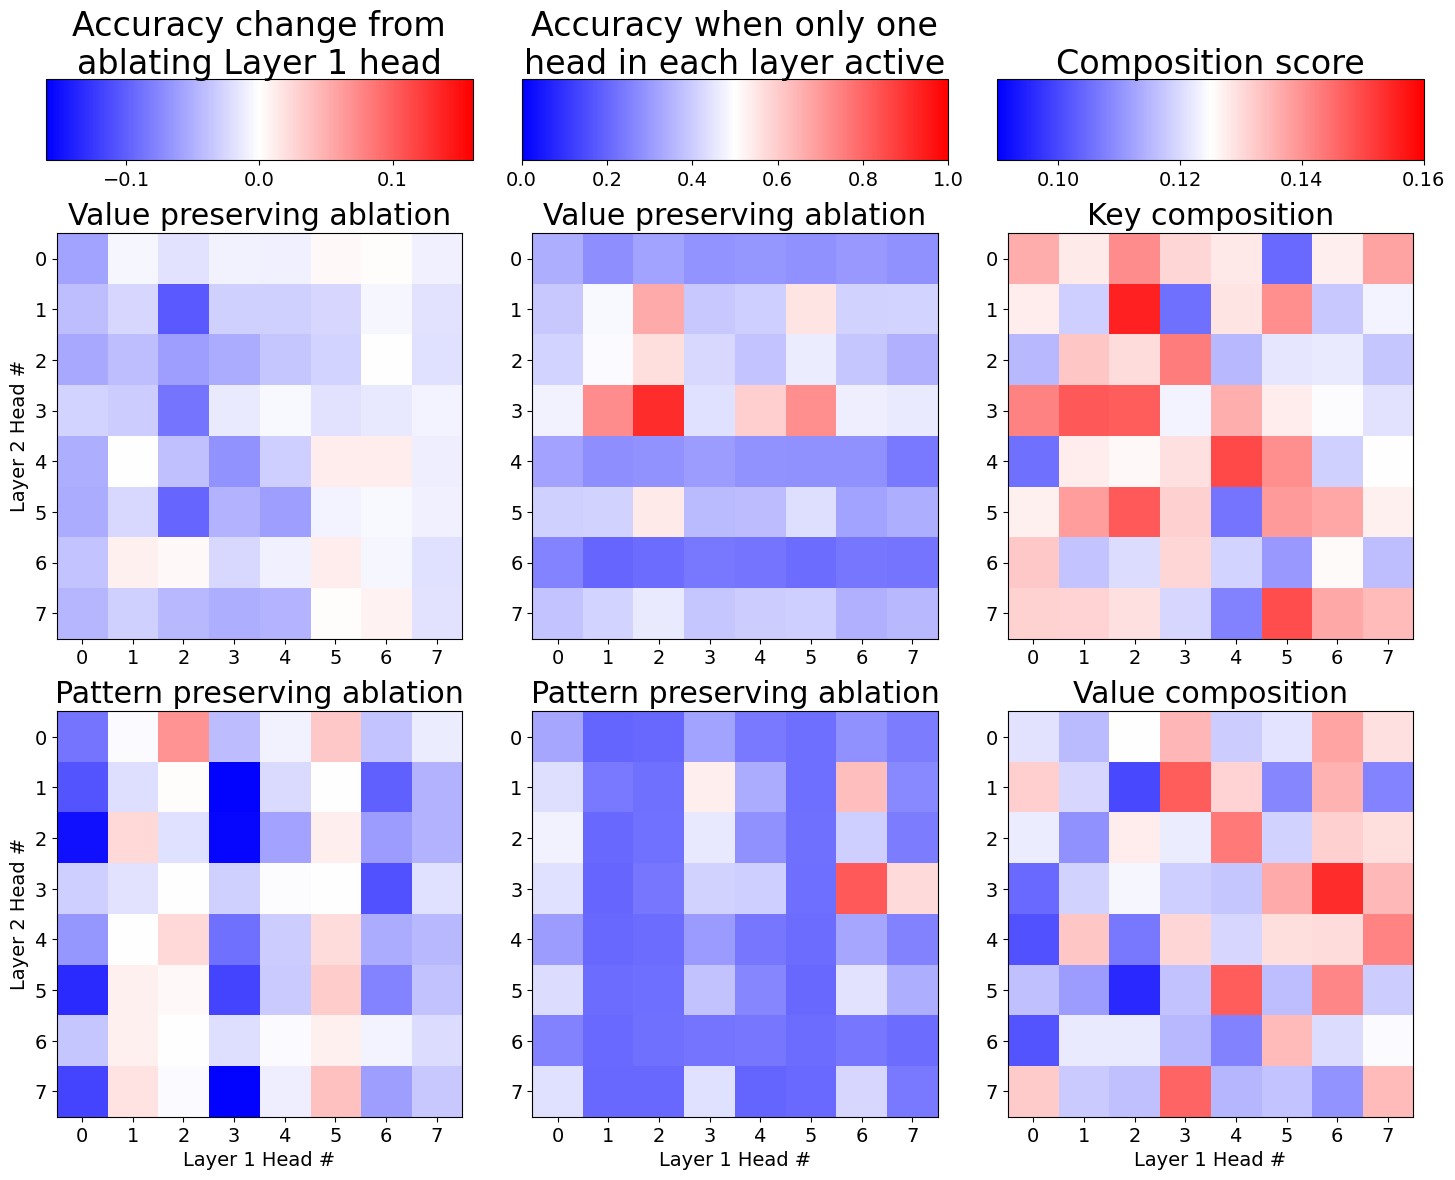

In [16]:
fig, axs = plt.subplots(3, 3, gridspec_kw={'height_ratios': [0.2, 1, 1]})
fig.set_size_inches(15, 12)
scales = {'all_but_one': [-0.16, 0.16], 'only_one': [0,1], 'cnxn': [0.09, 0.16]}
legend_titles = {'all_but_one': 'Accuracy change from\nablating Layer 1 head', 
                 'only_one': 'Accuracy when only one\nhead in each layer active', 
                 'cnxn': 'Composition score'}
matplotlib.rcParams.update({'font.size': 18})

for i, k in enumerate(heatmaps):
    im1 = axs[1, i].imshow(heatmaps[k]['pv'], cmap='bwr', vmin=scales[k][0], vmax=scales[k][1])
    axs[2, i].imshow(heatmaps[k]['pp'], cmap='bwr', vmin=scales[k][0], vmax=scales[k][1])
    axs[2, i].set_xlabel('Layer 1 Head #')
    if k == 'cnxn':
        axs[1, i].set_title('Key composition')
        axs[2, i].set_title('Value composition')
    else:
        axs[1, i].set_title('Value preserving ablation')
        axs[2, i].set_title('Pattern preserving ablation')
    
    for j in [1,2]:
        axs[j, i].set_xticks(np.arange(8))
        axs[j, i].set_yticks(np.arange(8))
    
    cbar = plt.colorbar(im1, cax=axs[0, i], orientation='horizontal')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label(legend_titles[k], size=24)
    
axs[1, 0].set_ylabel('Layer 2 Head #')
axs[2, 0].set_ylabel('Layer 2 Head #')
plt.tight_layout()

fig.savefig(f'{base_folder}/figures/appendix_figure_11.pdf')

#### Out of curiosity, we plotted composition scores at the start of training

In [17]:
composition_scores_init = dict(q=np.zeros((8,8)), k=np.zeros((8,8)), v=np.zeros((8,8)))
l1_inp = init_model.transformer.blocks[1].attn.qkv.weight.T
for l0_head in range(8):
    l0h_proj = init_model.transformer.blocks[0].attn.proj.weight.T[l0_head*8:(l0_head+1)*8, :]
    base = np.linalg.norm(l0h_proj)
    for i, k in enumerate('qkv'):
        for l1_head in range(8):
            mat = l1_inp[:, i*64+l1_head*8:i*64+(l1_head+1)*8]
            composition_scores_init[k][l1_head, l0_head] = np.linalg.norm(l0h_proj@mat)/(base*np.linalg.norm(mat))

heatmaps['cnxn_init'] = dict()
heatmaps['cnxn_init']['pv'] = composition_scores_init['k']
heatmaps['cnxn_init']['pp'] = composition_scores_init['v']

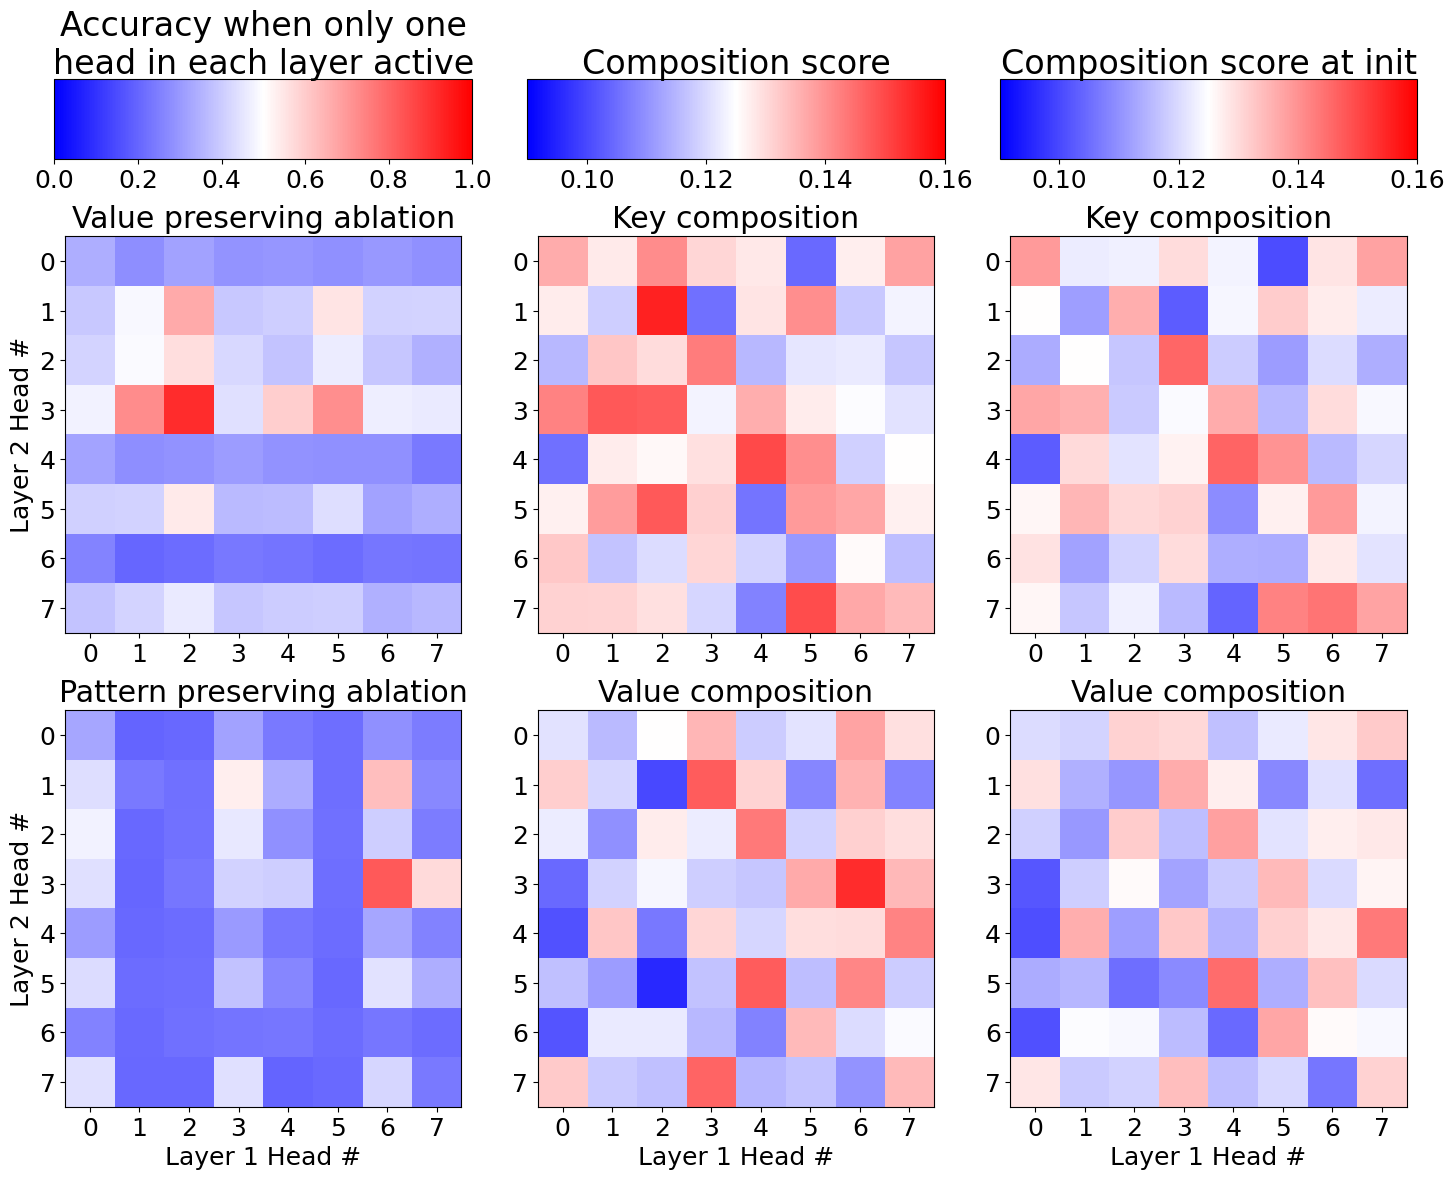

In [18]:
fig, axs = plt.subplots(3, 3, gridspec_kw={'height_ratios': [0.2, 1, 1]})
fig.set_size_inches(15, 12)
scales = {'only_one': [0,1], 'cnxn': [0.09, 0.16], 'cnxn_init': [0.09, 0.16]}
legend_titles = {'only_one': 'Accuracy when only one\nhead in each layer active', 
                 'cnxn': 'Composition score',
                 'cnxn_init': 'Composition score at init'}
matplotlib.rcParams.update({'font.size': 18})

for i, k in enumerate(legend_titles):
    im1 = axs[1, i].imshow(heatmaps[k]['pv'], cmap='bwr', vmin=scales[k][0], vmax=scales[k][1])
    axs[2, i].imshow(heatmaps[k]['pp'], cmap='bwr', vmin=scales[k][0], vmax=scales[k][1])
    axs[2, i].set_xlabel('Layer 1 Head #')
    if k.startswith('cnxn'):
        axs[1, i].set_title('Key composition')
        axs[2, i].set_title('Value composition')
    else:
        axs[1, i].set_title('Value preserving ablation')
        axs[2, i].set_title('Pattern preserving ablation')
    
    for j in [1,2]:
        axs[j, i].set_xticks(np.arange(8))
        axs[j, i].set_yticks(np.arange(8))
    
    cbar = plt.colorbar(im1, cax=axs[0, i], orientation='horizontal')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label(legend_titles[k], size=24)
    
axs[1, 0].set_ylabel('Layer 2 Head #')
axs[2, 0].set_ylabel('Layer 2 Head #')
plt.tight_layout()

# Doesn't appear in paper

Seems like there is some correlation, but not too meaningfully. E.g. the 4 -> 5 value composition lines up. We can see that the 3 -> 2 key composition is consistent but not functional (leftmost column). The strongest functional connections (2 -> 3 for key comp, 6 -> 3 for value comp) are not predicted by composition score at init (in fact, both have a lower composition score). 

One hypothesis for which pathways become crucial might be the ones that kind of already exist at init, but these results is a point against this hypothesis. Of course, further work would be needed to verify.

# Appendix F: Assorted figures

## Figure 12: No L1/L2 progress measure

Looking at the loss over time when we ablate one of the two layers outputs connection to the output

In [19]:
# Figure out which indices we'd like to plot, allowing for downsampling (for speed)
num_ckpts_to_plot = 100 # downsampled compared to paper for speed!
max_iters = 1e6

filenames = sorted(os.listdir(f'{base_folder}/omniglot50_rl5/checkpoints/'))
iters = np.array([int(cn.split('.')[0]) for cn in filenames])

inds_to_plot = ih_paper_plot_utils.get_closest_inds(np.linspace(iters[0], max_iters, num_ckpts_to_plot), iters)

In [20]:
# We make two forward fns, one for each progress measure
layer_progress_fns = dict()
temp_opts = deepcopy(default_opto_opts)
temp_opts.opto_ablate_heads = ['0:{}'.format(l) for l in range(8)]
temp_opts.opto_preserve_patterns = True
temp_opts.opto_preserve_values = True
layer_progress_fns['no_l0_output'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                                 batch_size=BATCH_SIZE)

temp_opts = deepcopy(default_opto_opts)
temp_opts.opto_ablate_heads = ['1:{}'.format(l) for l in range(8)]
layer_progress_fns['no_l1_output'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                                 batch_size=BATCH_SIZE)

Opto being used...
Opto being used...


In [21]:
series = {k: [] for k in layer_progress_fns}
for ind in tqdm(inds_to_plot):
    ckpt_fname = f'{base_folder}/omniglot50_rl5/checkpoints/{filenames[ind]}'
    ckpt = eqx.tree_deserialise_leaves(ckpt_fname, ckpt_fmt)
    for k in layer_progress_fns:
        series[k].append(jnp.mean(layer_progress_fns[k](ckpt['model'],
                                                         all_data['examples'], 
                                                         all_data['labels'], 
                                                         key=jax.random.PRNGKey(0))['loss'])
                        )

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/singha/miniconda3/envs/microformer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


In [22]:
# Since we want to subtract out the train loss, we have to align the x-values
# We use numpy's interpolation
f = h5.File(f'{base_folder}/omniglot50_rl5/log.h5', 'r')
interp_series = dict()
x = f['eval_iter'][:]
for k in series:
    interp_series[k] = np.interp(x, iters[inds_to_plot], series[k]) - np.mean(f['fsl_train']['loss'][:], axis=1)
f.close()

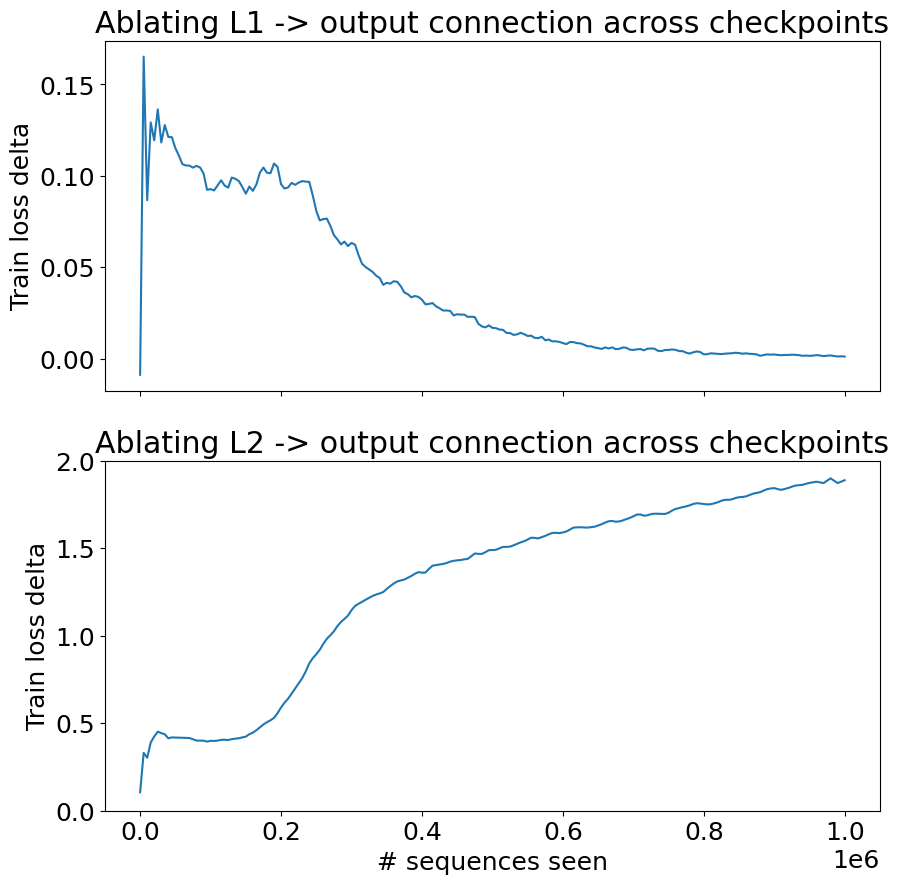

In [23]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(10, 10)
axs[0].plot(x, interp_series['no_l0_output'])
axs[0].set_title("Ablating L1 -> output connection across checkpoints")
axs[0].set_ylabel('Train loss delta')
axs[1].plot(x, interp_series['no_l1_output'])
axs[1].set_title("Ablating L2 -> output connection across checkpoints")
axs[1].set_ylabel('Train loss delta')
axs[1].set_ylim(0, 2)
axs[1].set_xlabel("# sequences seen")
fig.savefig(f'{base_folder}/figures/appendix_figure_12.pdf')

## Figure 13

See `ih_paper_plots.ipynb` as this one is constructed there

## Figure 14: Adding one head back at a time

In [24]:
# This ordering is manually written based on the induction head strength over time plot
# in `ih_paper_plots.ipynb`
HEAD_ORDERING = [3,1,2,7,5,0,4,6]
# The ordering does not matter that much to the result, which is just trying to 
# show the additive nature of IHs. We used this ordering to make it clearest visually.

adding_one_back_fns = dict()

for l in range(8):
    temp_opts = deepcopy(default_opto_opts)
    temp_opts.opto_ablate_heads = ['1:{}'.format(lay) for lay in range(8) if lay != l]
    adding_one_back_fns['only_l1h{}'.format(l)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                               batch_size=BATCH_SIZE)

for i in range(2, len(HEAD_ORDERING)):
    temp_opts = deepcopy(default_opto_opts)
    temp_opts.opto_ablate_heads = ['1:{}'.format(lay) for lay in HEAD_ORDERING[i:]]
    adding_one_back_fns['only_l1h3_first{}'.format(i)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                                       batch_size=BATCH_SIZE)

for i in range(3, len(HEAD_ORDERING)):
    temp_opts = deepcopy(default_opto_opts)
    temp_opts.opto_ablate_heads = ['1:3'] + ['1:{}'.format(lay) for lay in HEAD_ORDERING[i:]]
    adding_one_back_fns['only_l1h1_first{}'.format(i)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                                       batch_size=BATCH_SIZE)

Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...


In [25]:
adding_one_back_fns['orig'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(default_opto_opts, default_fn=fwd_fn_from_train), 
                                                                       batch_size=BATCH_SIZE)

In [26]:
adding_one_back_loss = dict()
for k in tqdm(adding_one_back_fns):
    retval = adding_one_back_fns[k](final_model, 
                                   all_data['examples'], 
                                   all_data['labels'], 
                                   key=jax.random.PRNGKey(0))
    adding_one_back_loss[k] = jnp.mean(retval['loss'])
    del retval

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/singha/miniconda3/envs/microformer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


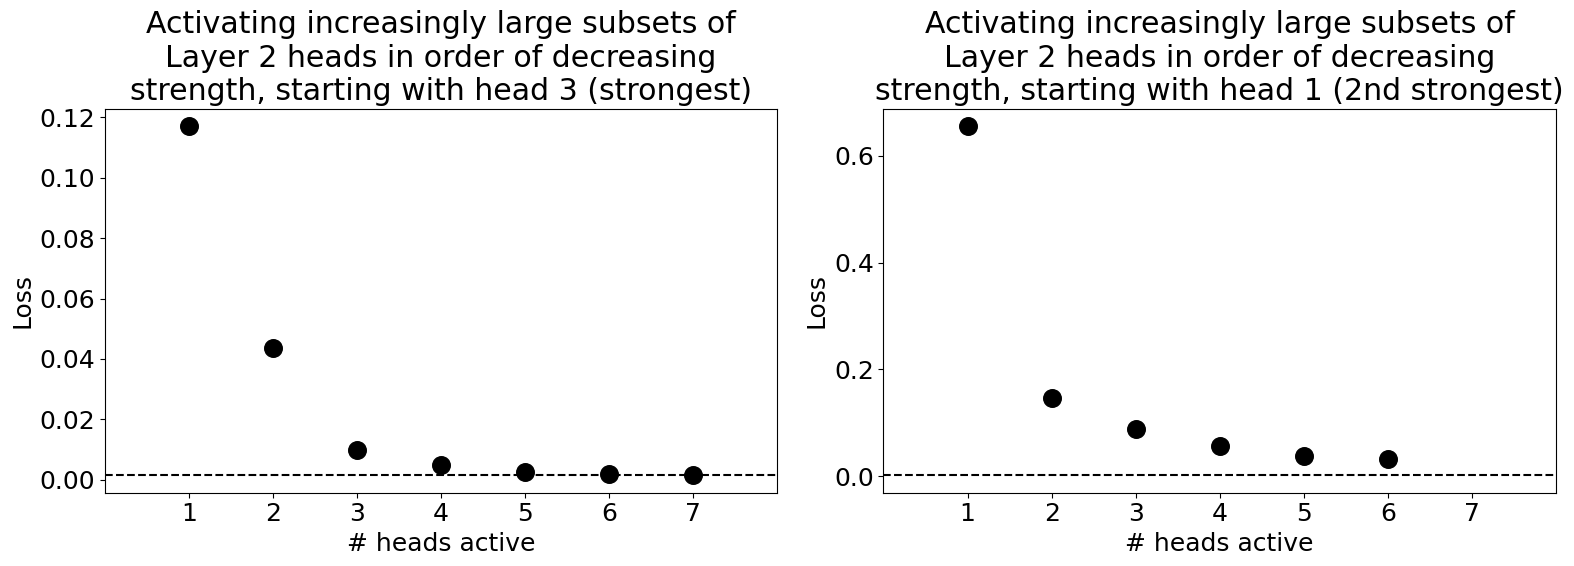

In [27]:
metric = 'loss'
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, sharex=True)
fig.set_size_inches(16,6)

axs[0].axhline(jnp.mean(adding_one_back_loss['orig']), c='k', ls='--', label='No ablation')
results = [adding_one_back_loss['only_l1h3']] + [adding_one_back_loss['only_l1h3_first{}'.format(l)] for l in range(2,8)]
axs[0].scatter(np.arange(1,8), results, c='k', marker='o', s=160)
axs[0].set_xlim(0, 8)
axs[0].set_xticks(np.arange(1, 8))
axs[0].set_xlabel('# heads active')
title = 'Activating increasingly large subsets of\nLayer 2 heads in order of decreasing\nstrength, starting with'
axs[0].set_title(title+' head 3 (strongest)')
axs[0].set_ylabel('Loss')

axs[1].axhline(adding_one_back_loss['orig'], c='k', ls='--', label='No ablation')
axs[1].scatter(np.arange(1,7), 
               [adding_one_back_loss['only_l1h1']] + [adding_one_back_loss['only_l1h1_first{}'.format(l)] for l in range(3,8)], 
               c='k', marker='o', s=160)
axs[1].set_title(title+' head 1 (2nd strongest)')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('# heads active')

plt.tight_layout()
fig.savefig(f'{base_folder}/figures/appendix_figure_14.pdf')

## Figure 15: Variable match loss curves

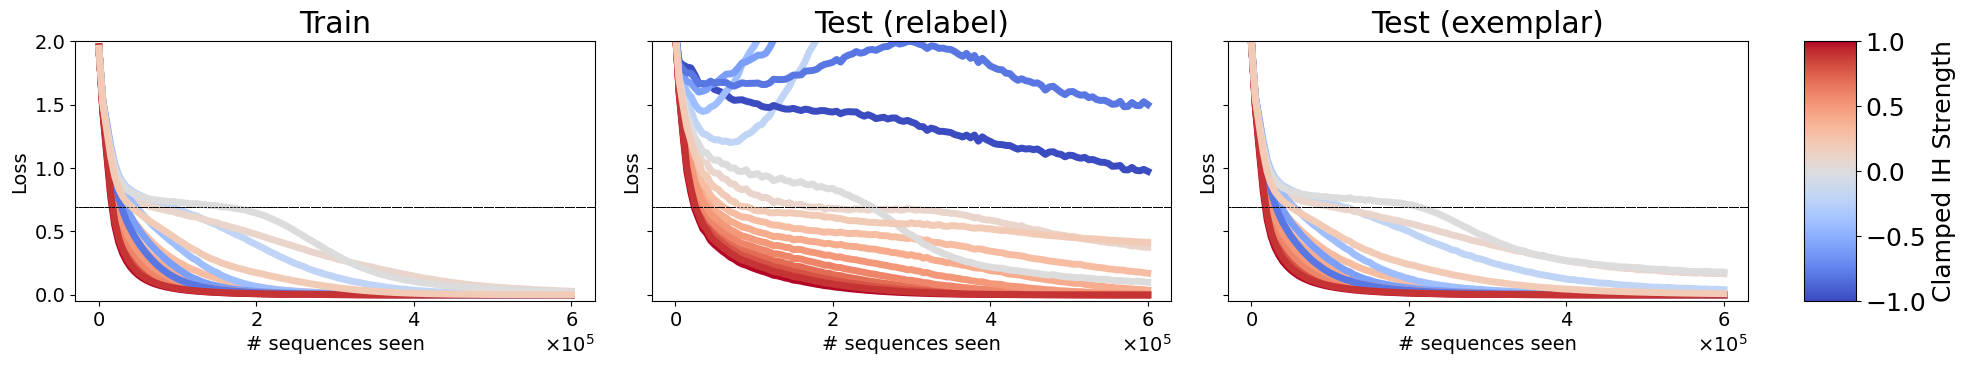

In [5]:
evals = {'fsl_train': 'Train', 'fsl_val_rl': 'Test (relabel)', 'fsl_test_class': 'Test (exemplar)'}
fig, axs = plt.subplots(1, len(evals)+1, sharex=True, sharey=True, 
                        gridspec_kw={'width_ratios': [1]*3+[0.1]})
fig.set_size_inches(20, 4)
matplotlib.rcParams.update({'font.size': 18})

var_match_dir = f'{base_folder}/ih{STRONGEST_IH}_strength'
for run in os.listdir(var_match_dir):
    f = h5.File('/'.join([var_match_dir, run, 'log.h5']))
    with open('/'.join([var_match_dir, run, 'config.json']), 'r') as cf:
        # 0 to 1
        strength = json.load(cf)['opto_induction_head_strength']
    
    iters = f['eval_iter'][:]
        
    for j, n in enumerate(evals):
        to_plot = f[f'{n}/loss'][:]
        color = plt.get_cmap('coolwarm')(strength)
        axs[j].plot(f['eval_iter'][:], np.mean(f[f'{n}/loss'][:], axis=1), color=color, lw=5)
        axs[j].axhline(np.log(2), color='k', ls='--', lw=0.5)
        axs[j].set_ylim([-0.05,2])
        
        axs[j].set_title(evals[n])
        axs[j].set_xlabel("# sequences seen")
        axs[j].set_ylabel('Loss')

    f.close()

axs[-1].remove()
colorbar_ax = fig.add_subplot(axs[0].get_gridspec()[:, -1])

sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('coolwarm'), 
                           norm=mcolors.Normalize(vmin=-1, vmax=1))
sm.set_array([])

ih_paper_plot_utils.scientific_notation_ticks(axs[0])

plt.colorbar(sm, label='Clamped IH Strength', cax=colorbar_ax)
plt.tight_layout()

fig.savefig(f'{base_folder}/figures/appendix_figure_15.pdf')

# Appendix G

## Table 2

See `ih_paper_plots.ipynb`

## Figure 16

In [29]:
rh_fns = dict()

for l in range(8):
    temp_opts = deepcopy(default_opto_opts)
    temp_opts.opto_ablate_heads = ['1:{}'.format(lay) for lay in range(8) if lay != l]
    rh_fns['only_l1h{}'.format(l)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                               batch_size=1024)
    
    temp_opts = deepcopy(default_opto_opts)
    temp_opts.opto_ablate_heads = ['1:{}'.format(lay) for lay in range(8) if lay != l]
    temp_opts.opto_induction_heads = ['1:{}'.format(l)]
    rh_fns['pm_only_l1h{}'.format(l)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                               batch_size=1024)

Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...


In [30]:
rh_fns['orig'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(default_opto_opts, default_fn=fwd_fn_from_train), 
                                       batch_size=BATCH_SIZE)

In [31]:
rh_no_act = dict()
for k in tqdm(rh_fns):
    out = rh_fns[k](final_model, all_data['examples'], all_data['labels'], key=jax.random.PRNGKey(0))
    del out['activations']
    rh_no_act[k] = out

  0%|          | 0/17 [00:00<?, ?it/s]

/Users/singha/miniconda3/envs/microformer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


In [32]:
# From ih_paper_plots.ipynb
# needed for x-axis on plot
final_strengths = [0.4180593192577362,
                     0.7359338402748108,
                     0.7082688808441162,
                     0.8452445268630981,
                     0.2888399362564087,
                     0.553320586681366,
                     0.10394389927387238,
                     0.5702829957008362]

/var/folders/58/_3hqdwzx443018vk2l47vwdr0000gn/T/ipykernel_12856/2091360387.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2')(np.arange(8))


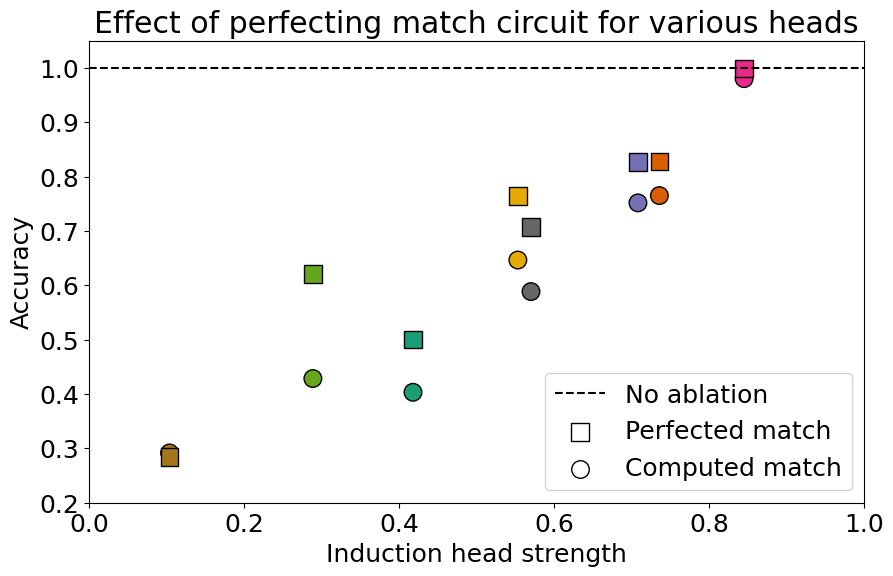

In [33]:
colors = plt.cm.get_cmap('Dark2')(np.arange(8))
metric = 'acc'
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)
axs.axhline(jnp.mean(rh_no_act['orig'][metric]), c='k', ls='--', label='No ablation')
axs.scatter(final_strengths, [jnp.mean(rh_no_act['only_l1h{}'.format(l)][metric]) for l in range(8)], 
            c=colors, marker='o', s=160, edgecolors='k')
axs.scatter(final_strengths, [jnp.mean(rh_no_act['pm_only_l1h{}'.format(l)][metric]) for l in range(8)], 
            c=colors, marker='s', s=160, edgecolors='k')
axs.set_xlim(0,1)
axs.set_ylim(0.2, 1.05)
axs.set_xlabel('Induction head strength')
axs.set_ylabel('Accuracy')
axs.set_title("Effect of perfecting match circuit for various heads")
axs.scatter([-10], [-10], marker='s', c='w', edgecolors='k', s=160, label='Perfected match')
axs.scatter([-10], [-10], marker='o', c='w', edgecolors='k', s=160, label='Computed match')

legend = axs.legend()

fig.savefig(f'{base_folder}/figures/appendix_figure_16a.pdf')

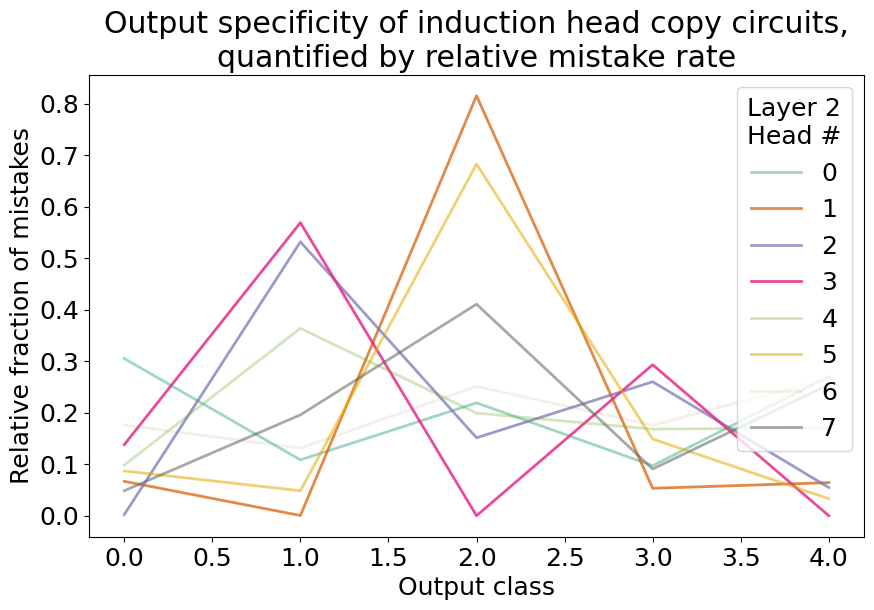

In [34]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)

for l in range(8):
    wrong_outputs = all_data['labels'][:, -1][jnp.logical_not(rh_no_act['pm_only_l1h{}'.format(l)]['acc'])]
    wrong_outputs_by_val = jnp.sum(jnp.arange(5)[:, None] == wrong_outputs[None, :], axis=1)
    plt.plot(wrong_outputs_by_val/jnp.sum(wrong_outputs_by_val), 
             c=colors[l], label=l, alpha=final_strengths[l], lw=2)

axs.legend(title='Layer 2\nHead #', loc='upper right')
axs.set_xlabel('Output class')
axs.set_xticks
axs.set_ylabel('Relative fraction of mistakes')
axs.set_title("Output specificity of induction head copy circuits,\nquantified by relative mistake rate")
fig.savefig(f'{base_folder}/figures/appendix_figure_16b.pdf')

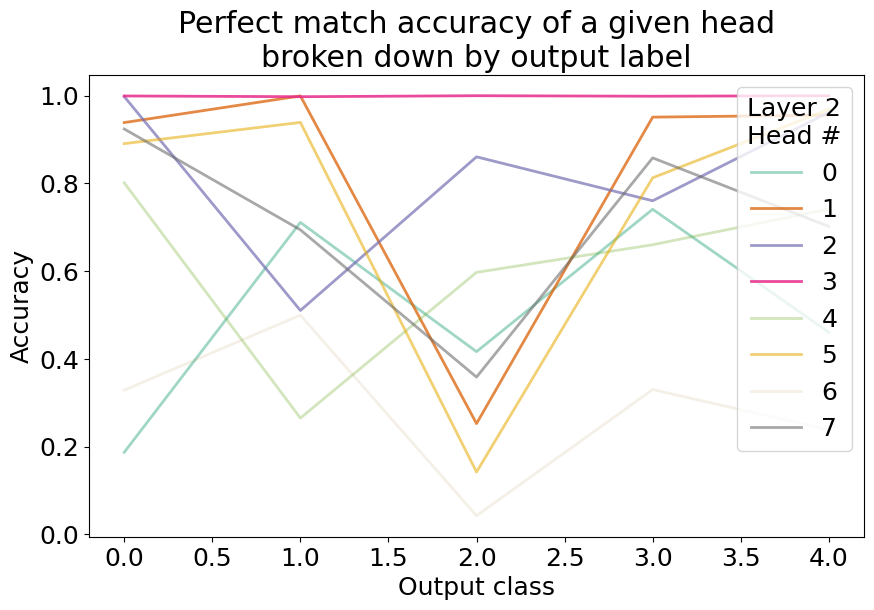

In [35]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)

count = jnp.sum(jnp.arange(5)[:, None] == all_data['labels'][:, -1][None, :], axis=1)

for l in range(8):
    correct = all_data['labels'][:, -1][rh_no_act['pm_only_l1h{}'.format(l)]['acc']]
    correct_by_val = jnp.sum(jnp.arange(5)[:, None] == correct[None, :], axis=1)
    plt.plot(correct_by_val/count,
             c=colors[l], label=l, alpha=final_strengths[l], lw=2)

axs.legend(title='Layer 2\nHead #', loc='upper right')
axs.set_xlabel('Output class')
axs.set_xticks
axs.set_ylabel('Accuracy')
axs.set_title("Perfect match accuracy of a given head\nbroken down by output label")
fig.savefig(f'{base_folder}/figures/appendix_figure_16c.pdf')

## Table 3

In [36]:
mistakes = jnp.sum(jnp.logical_not(rh_no_act['pm_only_l1h3']['acc']))
print("Total missed by h3", mistakes)
for l in range(8):
    comp_acc = rh_no_act['pm_only_l1h{}'.format(l)]['acc']
    right_not = jnp.logical_and(jnp.logical_not(rh_no_act['pm_only_l1h3']['acc']), comp_acc)
    print(l, jnp.sum(right_not)/mistakes, jnp.mean(comp_acc), jnp.sum(right_not)/(mistakes*jnp.mean(comp_acc)))

Total missed by h3 58
0 0.2413793 0.5004847 0.4822911
1 0.86206895 0.82804847 1.0410852
2 0.20689656 0.82728314 0.25009158
3 0.0 0.9992602 0.0
4 0.22413793 0.6209694 0.3609484
5 0.5 0.7642985 0.6541947
6 0.0 0.28459182 0.0
7 0.44827586 0.7070153 0.6340399


## Figure 17

/var/folders/58/_3hqdwzx443018vk2l47vwdr0000gn/T/ipykernel_12856/2307391109.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2')(np.arange(8))


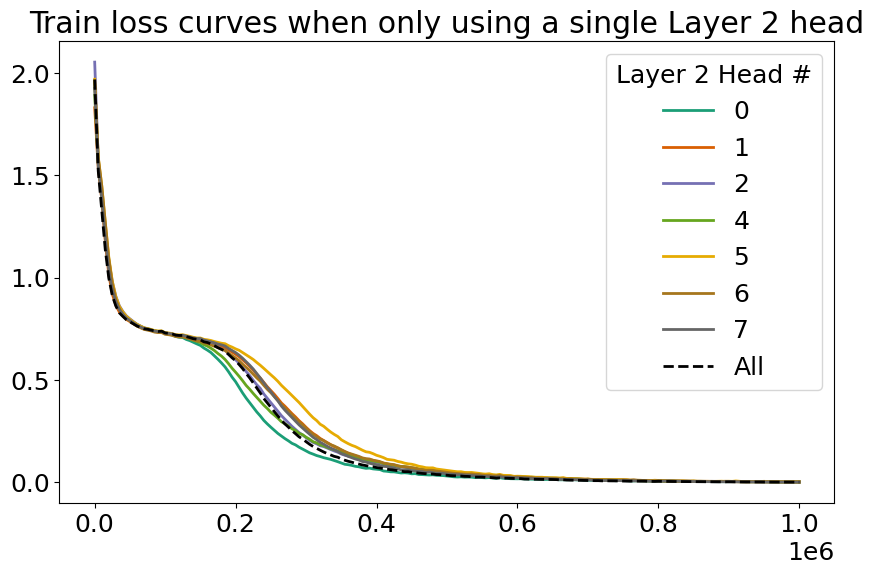

In [45]:
matplotlib.rcParams.update({'font.size': 18})
colors = plt.cm.get_cmap('Dark2')(np.arange(8))

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)

for i in range(7):
    all_poss = set(range(8))
    all_poss.remove(STRONGEST_IH)
    with open(f'{base_folder}/omniglot50_rl5_only_l1h{STRONGEST_IH}_and_iter{i}/config.json', 'r') as cfg:
        config = json.loads(cfg.read())
        left = all_poss - set([int(h.split(':')[-1]) for h in config['opto_ablate_heads']])
        head = left.pop()
    f = h5.File(f'{base_folder}/omniglot50_rl5_only_l1h{STRONGEST_IH}_and_iter{i}/log.h5', 'r')
    axs.plot(f['eval_iter'][:], np.mean(f['fsl_train']['loss'], axis=1), 
             color=colors[head], label=head, lw=2)
    f.close()
f = h5.File(f'{base_folder}/omniglot50_rl5/log.h5', 'r')
axs.plot(f['eval_iter'][:], np.mean(f['fsl_train']['loss'], axis=1), color='k', ls='--', label='All', lw=2)

axs.legend(title='Layer 2 Head #')
axs.set_title('Train loss curves when only using a single Layer 2 head')
fig.savefig(f'{base_folder}/figures/appendix_figure_17.pdf')

# Other initialization seeds

In [54]:
# These runs were made by using ih_paper_runs.sh with different values of INIT_SEED
seeds = list(range(5,10))
all_stats = dict()
for s in seeds:
    fn = f'ih_paper_reprod/main_paper_is{s}_ih3_pt2/figures/per_head_stats.pkl'
    if os.path.exists(fn):
        with open(fn, 'rb') as pf:
            all_stats[s] = pkl.load(pf)

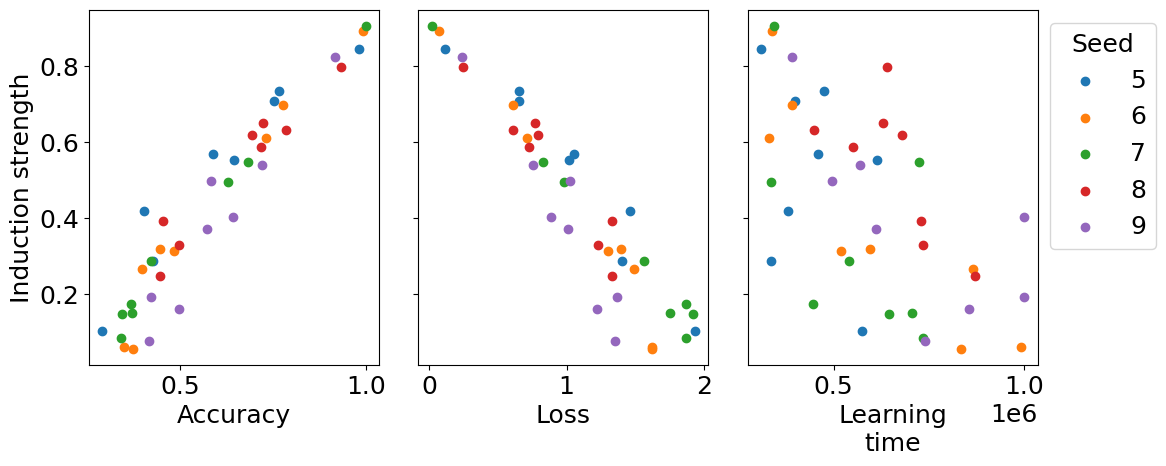

In [75]:
keys = list(all_stats[list(all_stats)[0]])
pairs = []
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        pairs.append((keys[i], keys[j]))

fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 5)

for s in seeds:
    axs[0].scatter(all_stats[s]['acc'], all_stats[s]['strength'], label=s)
    axs[1].scatter(all_stats[s]['loss'], all_stats[s]['strength'], label=s)
    axs[2].scatter(all_stats[s]['speed'], all_stats[s]['strength'], label=s)

axs[0].set_ylabel("Induction strength")
axs[0].set_xlabel("Accuracy")
axs[1].set_xlabel("Loss")
axs[2].set_xlabel("Learning\ntime")

axs[2].legend(title='Seed', bbox_to_anchor=[1,1])

plt.tight_layout()

fig.savefig(f'{base_folder}/figures/appendix_figure_18.pdf')